In [1]:
%matplotlib inline
import json 
# import tables 
import numpy as np 
from collections import defaultdict, Counter
import random
import matplotlib.pyplot as plt 

DATA_PATH = "/net/people/plgczyjtu/behavioural_cloning/data/tmnf_1os_ds.hdf5"


In [30]:
import torch as th
import torch.utils.data as th_data
import torchvision.transforms.functional as VF
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path
from tqdm import tqdm 


CLIP_INDICES = (380, 730, 10, -10)
ORIGINAL_SHAPE = (800, 1000)
SCALED_MAX_SIDE = 128


def get_dataset(img_folder: Path) -> th.Tensor:#th_data.TensorDataset:
    transform = transforms.Compose(
        [
            lambda i: VF.crop(
                i,
                top=CLIP_INDICES[0],
                left=CLIP_INDICES[2],
                height=CLIP_INDICES[1] - CLIP_INDICES[0],
                width=ORIGINAL_SHAPE[1] - CLIP_INDICES[2] + CLIP_INDICES[3],
            ),
            transforms.Resize((SCALED_MAX_SIDE, SCALED_MAX_SIDE))
        ]
    )

    images = []
    paths = list(img_folder.glob("*/*.jpeg"))
    for img_path in tqdm(paths):
        img = read_image(str(img_path))
        img = transform(img) / 255
        images.append(img)
    # dataset = th_data.TensorDataset(th.stack(images, dim=0))
    return th.stack(images)


In [75]:
import torch
import torch as th 
from torch.nn import functional as F
from typing import Optional 

DEVICE = "cuda" if th.cuda.is_available() else "cpu"


def DownamplingBlock(in_channels, n_dims) -> th.nn.Module:
    return th.nn.Sequential(
        th.nn.Conv2d(
            in_channels,
            out_channels=n_dims,
            kernel_size=3,
            stride=2,
            padding=1
        ),
        th.nn.BatchNorm2d(n_dims),
        th.nn.LeakyReLU(),
    )

def UpsamplingBlock(in_channels, n_dims) -> th.nn.Module:
    return th.nn.Sequential(
        th.nn.ConvTranspose2d(
            in_channels,
            n_dims,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        ),
        th.nn.BatchNorm2d(n_dims),
        th.nn.LeakyReLU(),
    )

class VanillaVAE(th.nn.Module):
    def __init__(
        self, in_channels: int, latent_dim: int, hidden_dims: Optional[list[int]] = None
    ) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.h, self.w = 4, 4
        self.hidden_dims = hidden_dims or [16, 32, 64, 128, 128]

        modules: list[th.nn.Module] = []
        encoder_dims = [in_channels] + self.hidden_dims
        for i in range(len(encoder_dims) - 1):
            modules.append(
                DownamplingBlock(encoder_dims[i], encoder_dims[i + 1])
            )
        self.encoder = th.nn.Sequential(*modules)
        self.encoder_fc = th.nn.Linear(self.hidden_dims[-1]  * self.h * self.w, self.hidden_dims[-1])

        self.fc_mu = th.nn.Linear(self.hidden_dims[-1], latent_dim)
        self.fc_var = th.nn.Linear(self.hidden_dims[-1], latent_dim)


        # Build Decoder
       
        decoder_dims = self.hidden_dims[::-1] + [in_channels]
        self.decoder_fc = th.nn.Sequential(
            th.nn.Linear(latent_dim, self.hidden_dims[-1]),
            th.nn.LeakyReLU(),
            th.nn.Linear(self.hidden_dims[-1], self.hidden_dims[-1] * self.w * self.h),
            th.nn.LeakyReLU()
        )
        modules: list[th.nn.Module] = []
        for i in range(len(decoder_dims) - 1):
            modules.append(
                UpsamplingBlock(decoder_dims[i], decoder_dims[i + 1])
            )

        self.decoder = th.nn.Sequential(*modules)


    def encode(self, X: th.Tensor) -> tuple[th.Tensor, th.Tensor]:
        X = self.encoder(X)
        X = torch.flatten(X, start_dim=1)
        
        X = self.encoder_fc(X)
        X = th.nn.functional.leaky_relu(X)

        mu = self.fc_mu(X)
        log_var = self.fc_var(X)
        return mu, log_var

    def decode(self, Z: th.Tensor) -> th.Tensor:
        X = self.decoder_fc(Z)
        X = X.view(-1, self.hidden_dims[-1], self.h, self.w)
        X = self.decoder(X)
        X = F.sigmoid(X)
        return X

    def reparameterize(self, mu: th.Tensor, logvar: th.Tensor) -> th.Tensor:
        sigma = torch.exp(logvar)
        return mu + sigma * th.randn(mu.size()).to(DEVICE)

    def forward(self, X: th.Tensor, **kwargs) -> tuple[th.Tensor, th.Tensor, th.Tensor, th.Tensor]:
        mu, log_var = self.encode(X)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), X, mu, log_var

    def loss_function(self, recons, input, mu, log_var, kld_weight: float) -> dict:
        recons_loss = F.mse_loss(recons, input)
        sigma = th.exp(log_var)
        kld_loss = (sigma**2 + mu**2 - log_var - 1/2).sum()

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }

    def sample(self, num_samples: int, current_device: int, **kwargs) -> th.Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples, self.latent_dim)

        z = z.to(DEVICE)

        samples = self.decode(z)
        return samples

    def generate(self, x: th.Tensor, **kwargs) -> th.Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]


In [76]:
TRAIN_DATASET, VALID_DATASET = None, None

In [83]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb 
from torchvision.utils import make_grid

class VAE(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.vae = VanillaVAE(3, 128, [8, 16, 32, 32, 32]).to(DEVICE)

    def training_step(self, batch, batch_idx) -> dict[str, th.Tensor]:
        X = batch[0]
        X_hat, X, mu, log_var = self.vae(X)
        info = self.vae.loss_function(X_hat, X, mu, log_var, kld_weight=1)
        self.log_dict(info)
        return info["loss"]

    def validation_step(self, batch, batch_idx) -> dict[str, th.Tensor]:
        X = batch[0]
        X_hat, X, mu, log_var = self.vae(X)
        info = self.vae.loss_function(X_hat, X, mu, log_var, kld_weight=1)
        self.log_dict({name + "_val": value for name, value in info.items()})
        if batch_idx == 0:
            X_grid = make_grid(X, 8)
            X_hat_grid = make_grid(X_hat, 8)
            self.logger.log_image(key="validation_batch", images=[X_grid, X_hat_grid], caption=["original", "reconstructed"])
        return info["loss"]

    def configure_optimizers(self):
        optimizer = th.optim.Adam(self.parameters(), lr=5e-4)
        return optimizer


def train():
    global TRAIN_DATASET, VALID_DATASET
    wandb.finish()
    if TRAIN_DATASET is None or VALID_DATASET is None:
        PATH = Path("/net/people/plgczyjtu/vae/data/trackmania")
        data = get_dataset(PATH)
        dataset = th_data.TensorDataset(data.to(DEVICE))

        val_proc = 0.1
        val_len = int(len(data) * val_proc)
        TRAIN_DATASET, VALID_DATASET = th_data.random_split(dataset, [len(data) - val_len, val_len])

    dataloader = th_data.DataLoader(TRAIN_DATASET, batch_size=64)
    valid_loader = th_data.DataLoader(VALID_DATASET, batch_size=64)


    wandb_logger = WandbLogger(project="VAE", log_model="all")
    model= VAE()
    trainer = pl.Trainer(logger=wandb_logger, max_epochs=150, log_every_n_steps=1, accelerator="gpu")
    trainer.fit(model=model, train_dataloaders=dataloader, val_dataloaders=valid_loader)
    wandb.finish()

In [84]:
train()

100%|██████████| 44923/44923 [08:12<00:00, 91.14it/s] 


/net/people/plgczyjtu/vae/venv/lib/python3.9/site-packages/lightning_lite/plugins/environments/slurm.py:167: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /net/people/plgczyjtu/vae/venv/lib/python3.9/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | vae  | VanillaVAE | 95.3 K
------------------------------------
95.3 K    Trainable params
0         Non-trainable params
95.3 K    Total params
0.381     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/net/people/plgczyjtu/vae/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/net/people/plgczyjtu/vae/venv/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/net/people/plgczyjtu/vae/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) i

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [41]:
checkpoint = "automobile-racing-toolbox/VAE/model-13bmun53:best"
with wandb.init(project="VAE") as run:
    artifact = run.use_artifact(checkpoint, type="model")
    artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


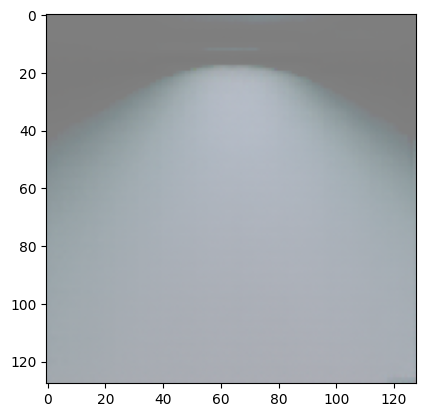

In [45]:
model = VAE.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")
model.vae.eval()

with th.no_grad():
    img = model.vae.generate(data[10].unsqueeze(0).to(DEVICE))
plt.imshow(img[0].permute(1, 2, 0).detach().cpu())

In [64]:
b = next(iter(th_data.DataLoader(TRAIN_DATASET, batch_size=64)))[0]
g = make_grid(b, 8)

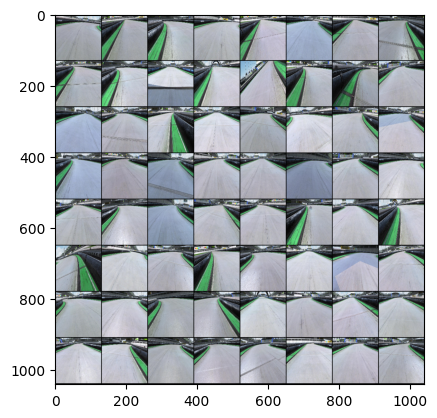

In [65]:
plt.imshow(g.permute(1, 2, 0).detach().cpu())